# Airfare Prediction

## Content

1. [Introduction](#1)
2. [The Data](#2)
3. [Exploratory Data Analysis](#3)
4. [Analysis](#4)
5. [Hyper Parameter Tuning](#5)
6. [Model Saving](#6)

## Introduction <a name = '1'></a>

Airfare might be very hard to guess. Since they follow a dynamic pricing model, the prices constantly change based on demand as well as flight timings. This often leads to unpleasant suirprices while booking air tickets. 

This model will try to address this unpredictability issue by building a model that can predict flight ticket prices. 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score

import datetime
import warnings
warnings.filterwarnings('ignore')

## The Data <a name = '2'></a>

In [2]:
airfareDf = pd.read_excel('Data_Train.xlsx')
airfareDf.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
airfareDf.shape

(10683, 11)

The dataset has 10,683 rows and 11 columns.

## Exploratory Data Analysis <a name = '3'></a>

In [4]:
airfareDf.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

The column 'Route' and 'Total_Stops' have a missing value.

In [5]:
#Inspecting the row with missing value
airfareDf[airfareDf['Route'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [6]:
#finding the mode of column Route for all flight with source Delhi and destinaiton Cochin
airfareDf[(airfareDf['Source'] == 'Delhi') & (airfareDf['Destination'] == 'Cochin')]['Route'].mode()[0]

'DEL → BOM → COK'

In [7]:
#Replacing the mode found above in the missing place in Route column
airfareDf['Route'] = airfareDf['Route'].fillna('DEL → BOM → COK')
airfareDf['Route'].isnull().sum()

0

In [8]:
#Since the mode for route is 'DEL → BOM → COK', this means there is only one stop
#So we will replace the missing value in 'Total_Stops' with '1 stop'
airfareDf['Total_Stops'] = airfareDf['Total_Stops'].fillna('1 stop')
airfareDf.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [9]:
#Checking dataypes
airfareDf.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

All the columns have the correct datatype except Date column which should be DateTime datatype.

In [10]:
#Changing the datatype of date column
airfareDf['Date_of_Journey'] = pd.to_datetime(airfareDf['Date_of_Journey']).dt.date

In [11]:
#Using the Day_of_Jouney column to impute the day of the week and making a new column
#0 --> Monday and 1 --> Tuesday and so on
airfareDf['Day_of_Journey'] = airfareDf['Date_of_Journey'].map(lambda a: a.weekday())
airfareDf.drop('Date_of_Journey', axis = 1, inplace = True)

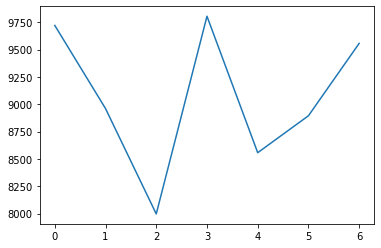

In [12]:
plt.plot(airfareDf.groupby('Day_of_Journey')['Price'].mean())

We see that the mean flight price is the highest on Mondays and Thrusdays while it is the lowest on Wednesdays.

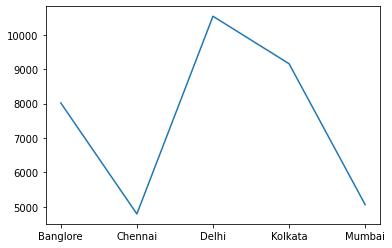

In [13]:
plt.plot(airfareDf.groupby('Source')['Price'].mean())

The flights originating from Delhi have the highest mean price and those originating from Chennai and Mumbai have the lowest mean price.

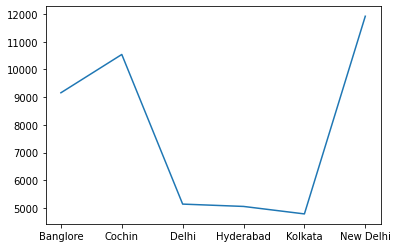

In [14]:
plt.plot(airfareDf.groupby('Destination')['Price'].mean())

Flights flying to New Delhi have the highest mean price and those flying to Kolkata have the lowest mean price.

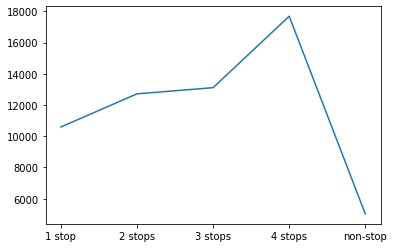

In [15]:
plt.plot(airfareDf.groupby('Total_Stops')['Price'].mean())

Non-stop flights seems to be the cheapest. As the number of stops increases, the mean flight price also increases.

In [16]:
#Checking steps to convert duration from string to int
a = '7h 25m'.split()

In [17]:
(int(a[0][0])*60)+int(a[1][1])

425

In [18]:
#Making a function to implement the above steps and convert duration in strings to in minutes (as int)
def durationConverter(duration):
    try:
        a = duration.split()
        if len(a) > 1:
            return (int(a[0][0])*60)+int(a[1][1])
        elif len(a) == 1:
            return (int(a[0][0])*60)
    except ValueError:
        a = duration.split()
        if len(a) > 1:
            return (int(a[0][0])*60)+int(a[1][0])

In [19]:
#Making a new column and applying the above function to get the durating in minutes
airfareDf['Duration_in_Minutes'] = airfareDf['Duration'].map(durationConverter)

<AxesSubplot:xlabel='Duration_in_Minutes', ylabel='Price'>

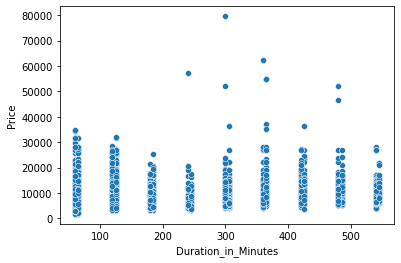

In [20]:
sns.scatterplot(x = 'Duration_in_Minutes', y = 'Price', data = airfareDf)

<AxesSubplot:xlabel='Duration_in_Minutes', ylabel='Price'>

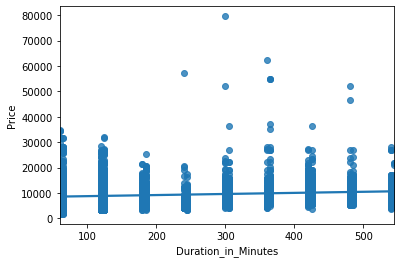

In [21]:
sns.regplot(x = 'Duration_in_Minutes', y = 'Price', data = airfareDf)

In [22]:
stat.pearsonr(airfareDf['Duration_in_Minutes'], airfareDf['Price'])

(0.12901069804693963, 7.031890473474225e-41)

From the two figures and the Pearson correlation test, we see that Duration_in_Minutes is not a good predictor of Price. Therefore, we will drop this column as well the original column from where we derived the Duration_in_Minutes column.

In [23]:
#Not a big contributor. Will drop
airfareDf.drop(['Duration', 'Duration_in_Minutes'], axis = 1, inplace = True)

In [24]:
#The information from column Route is taken into account in the column 'Total_Stops'
#So we will drop this column as well
airfareDf.drop('Route', axis = 1, inplace = True)

In [25]:
#From above we know that price increases as number od stops increase
#Therefore, we will assign higher numbers as number of stops increase
stopMap = {'non-stop': 0, '1 stop': 1,'2 stops': 2,'3 stops': 3, '4 stops': 4 }

In [26]:
#LAbel encoding the 'Total_Stops' column and then droping the original 'Total_Stops column'
airfareDf['Total_stop_encoded'] = airfareDf['Total_Stops'].map(stopMap)
airfareDf.drop('Total_Stops', axis = 1, inplace = True)

In [27]:
#Checking the labels and their frequencies in the Addtional_Info column
airfareDf['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
Red-eye flight                     1
1 Short layover                    1
2 Long layover                     1
Name: Additional_Info, dtype: int64

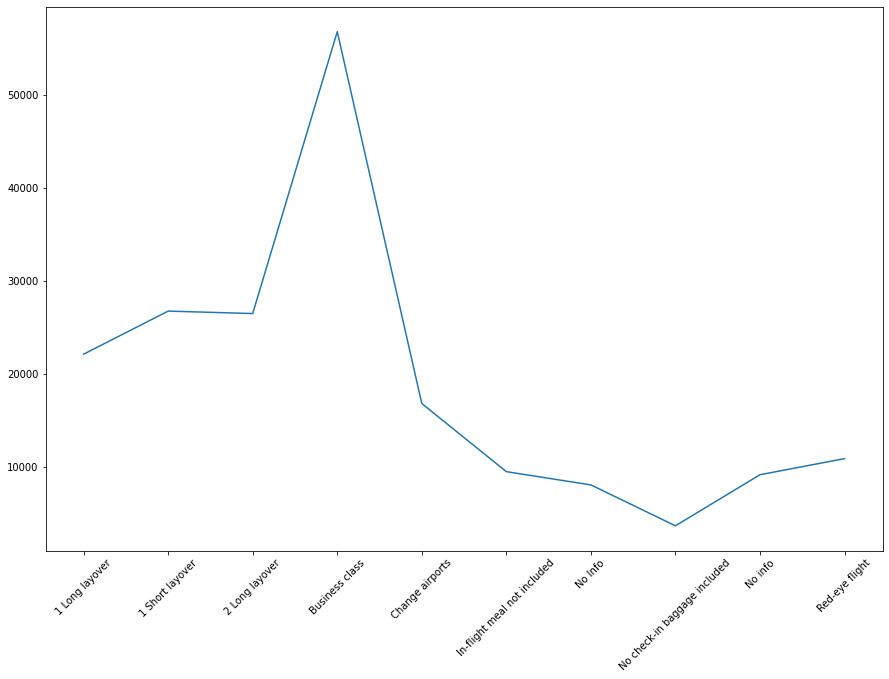

In [28]:
plt.figure(figsize=(15,10))
plt.xticks(rotation = 45)
plt.plot(airfareDf.groupby('Additional_Info')['Price'].mean())

Here we see that the labels 'Business_class', '1LongLayover', '1ShortLayover' and '2LongLayover' have higer mean proce while the other labels have very low mean price. Therefore, we will perform OneHotEncoding on only these columns and ignore the rest. We will then drop the 'Additional_Info' column.

In [29]:
airfareDf['Business_class'] = np.where(airfareDf['Additional_Info'] == 'Business class', 1, 0)
airfareDf['1LongLayover'] = np.where(airfareDf['Additional_Info'] == '1 Long layover', 1, 0)
airfareDf['1ShortLayover'] = np.where(airfareDf['Additional_Info'] == '1 Short layover', 1, 0)
airfareDf['2LongLayover'] = np.where(airfareDf['Additional_Info'] == '2 Long layover', 1, 0)

airfareDf.drop('Additional_Info', axis = 1, inplace = True)

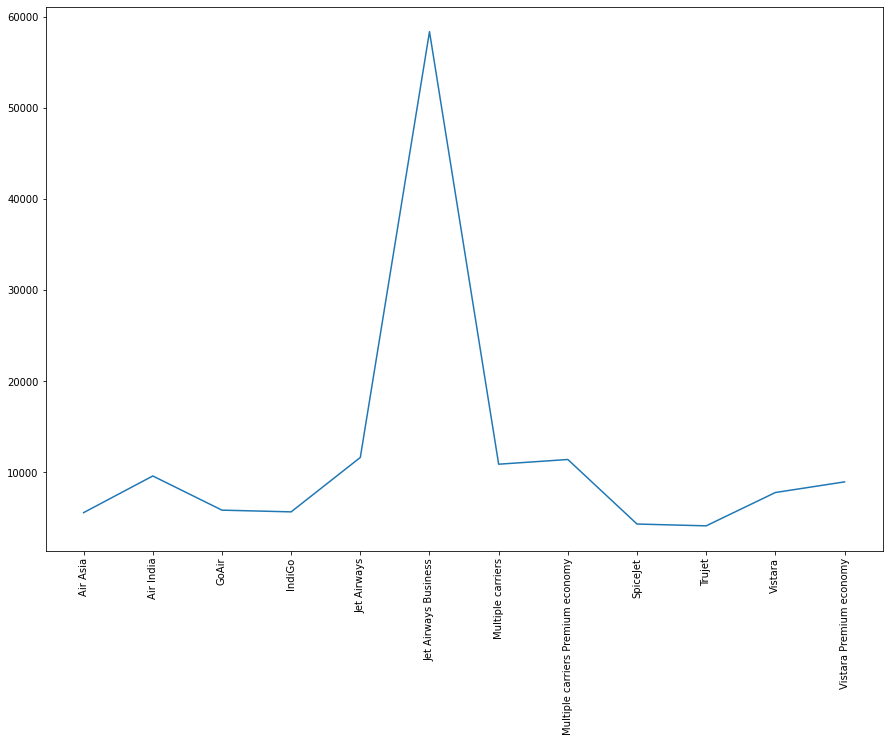

In [30]:
plt.figure(figsize=(15,10))
plt.xticks(rotation = 90)
plt.plot(airfareDf.groupby('Airline')['Price'].mean())

From the above we see that 'Jet Airways Business' has the highest mean while other airliners have a lower mean. We will use this information to perform label encoding of airlines. Airliners with high mean price will get high numeric labels and vise-versa.

In [31]:
airlineMap = {'Jet Airways Business': 3, 
             'Air India': 2,
             'Jet Airways': 2,
             'Multiple carriers': 2,
             'Vistara Premium economy': 2,
             'Multiple carriers Premium economy': 2,
             'Air Asia': 1,
             'GoAir': 1,
             'IndiGo': 1,
             'SpiceJet': 1,
             'Trujet': 1,
             'Vistara': 1}

In [32]:
#Making a new label encoded column for airlines
airfareDf['Airline_encoded'] = airfareDf['Airline'].map(airlineMap)
airfareDf.drop('Airline', axis = 1, inplace = True)

In [33]:
#Making a new column containing only the hour of the day the flight departed
airfareDf['Dep_Time'] = airfareDf['Dep_Time'].map(lambda i: int(i.split(':')[0]))
airfareDf = airfareDf.astype({'Dep_Time': 'int64'})

In [34]:
#Making a new column containing only the hour of the day the flight arrived
airfareDf['Arrival_Time'] = airfareDf['Arrival_Time'].map(lambda i: int(i.split(':')[0]))
airfareDf = airfareDf.astype({'Arrival_Time': 'int64'})

In [35]:
#making a function to label the period of the day based on the time
def periodOfDay(time):
    if time > 0 and time < 12:
        return 'Morning'
    elif time >=12 and time <= 17:
        return 'Afternoon'
    elif time >=18 and time <=23:
        return 'Night'
    elif time == 0:
        return 'Night'

In [36]:
#Making a new column and applying the function above to find the period of the day when the flight departed
airfareDf['Dep_TimeOfDay'] = airfareDf['Dep_Time'].map(periodOfDay)

In [37]:
#Making a new column and applying the function above to find the period of the day when the flight arrived
airfareDf['Arrival_TimeOfDay'] = airfareDf['Arrival_Time'].map(periodOfDay)

In [38]:
#Since we have extracted the information from these columns, we will drop them
airfareDf.drop(['Dep_Time', 'Arrival_Time'], axis = 1, inplace = True)

In [39]:
airfareDf = pd.get_dummies(airfareDf, columns=['Source', 'Destination', 'Dep_TimeOfDay', 'Arrival_TimeOfDay'])

## Analysis <a name = '4'></a>

In [40]:
x = airfareDf.drop('Price', axis = 1)
y = airfareDf['Price']

In [41]:
#Finding the best random state
maxAcc = 0
maxRs = 0
for randState in range(0,200):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=randState)
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    predlr = lr.predict(x_test)
    acc = lr.score(x_test, y_test)*100
    if acc>maxAcc:
        maxAcc=acc
        maxRs=randState
print(f"Best accuracy is {round(maxAcc, 2)}% on Random state {randState}")

Best accuracy is 60.59% on Random state 199


In [42]:
#Splitting the x and y into train and test data with the best random state from above
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=199)

In [43]:
#Fitting various regression models to the train data and printing their perfomance metrics one-by-one
lr = LinearRegression()
rfr = RandomForestRegressor()
dtr = DecisionTreeRegressor()
svr = SVR()
knr = KNeighborsRegressor()
mlp = MLPRegressor()

models = [lr, rfr, dtr, svr, knr, mlp]

for model in models:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    predTrain = model.predict(x_train)
    print(f'{model}\n\tAccuracy: {model.score(x_test, y_test)}\n\tMSE: {mean_squared_error(y_test, pred)}\n\tRMSE: {mean_squared_error(y_test, pred)**(1/2)}\n\tR2 Score: {r2_score(y_test, pred)}\n\tTrain-Test difference: {r2_score(y_train, predTrain)-r2_score(y_test, pred)}')

LinearRegression()
	Accuracy: 0.542708883580642
	MSE: 10549378.458586805
	RMSE: 3247.980673986039
	R2 Score: 0.542708883580642
	Train-Test difference: 0.0015565802614873059
RandomForestRegressor()
	Accuracy: 0.6150532618034664
	MSE: 8880445.479526173
	RMSE: 2980.0076307832123
	R2 Score: 0.6150532618034664
	Train-Test difference: 0.07028634587866933
DecisionTreeRegressor()
	Accuracy: 0.5958351306936129
	MSE: 9323793.996619742
	RMSE: 3053.4888237260247
	R2 Score: 0.5958351306936129
	Train-Test difference: 0.09217817916215354
SVR()
	Accuracy: 0.02215431873528728
	MSE: 22558199.351277437
	RMSE: 4749.547278560078
	R2 Score: 0.02215431873528728
	Train-Test difference: 0.010700089102840704
KNeighborsRegressor()
	Accuracy: 0.5516929886968049
	MSE: 10342121.589649042
	RMSE: 3215.9169127402906
	R2 Score: 0.5516929886968049
	Train-Test difference: 0.05547138881337932
MLPRegressor()
	Accuracy: 0.4726217654272684
	MSE: 12166238.064915968
	RMSE: 3488.0134840501933
	R2 Score: 0.4726217654272684
	Trai

Since Linear Regression has the least train-test score difference, we will select this algorithm as the final model

## Hyper Parameter Tuning <a name = '5'></a>

In [44]:
#Linear Regression Hyperparameters
lrParameters = {'fit_intercept': [True, False],
             'normalize': [True, False],
             'positive': [True, False]}

In [45]:
lrGS = GridSearchCV(lr, param_grid = lrParameters, cv = 5, scoring = 'r2', n_jobs = -1)

In [46]:
lrGS.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False],
                         'positive': [True, False]},
             scoring='r2')

In [47]:
lrGS.best_params_

{'fit_intercept': False, 'normalize': True, 'positive': True}

In [48]:
lr = LinearRegression(fit_intercept = False, normalize = True, positive = True)

lr.fit(x_train, y_train)

pred = lr.predict(x_test)
predTrain = lr.predict(x_train)

print(f'R2 Score for test data after hyperparameter tuning: {r2_score(y_test, pred)}')
print(f'R2 Score for train data after hyperparameter tuning: {r2_score(y_train, predTrain)}')

R2 Score for test data after hyperparameter tuning: 0.5418924488107211
R2 Score for train data after hyperparameter tuning: 0.5439683814798686


In [49]:
from sklearn.model_selection import GridSearchCV
parameters = {'criterion' : ['mse', 'mae'],
             'max_depth': np.arange(2, 15),
             'n_estimators' : [10, 50, 75, 150, 300, 600]}

rsRfr = RandomizedSearchCV(rfr, parameters, cv=5, scoring = 'r2')
rsRfr.fit(x_train, y_train)
rsRfr.best_params_

{'n_estimators': 75, 'max_depth': 9, 'criterion': 'mse'}

In [50]:
rfr = RandomForestRegressor(criterion = 'mse', max_depth = 8, n_estimators = 75)
rfr.fit(x_train, y_train)

pred = rfr.predict(x_test)
predTrain = rfr.predict(x_train)

print(f'R2 Score for test data after hyperparameter tuning: {r2_score(y_test, pred)}')
print(f'R2 Score for train data after hyperparameter tuning: {r2_score(y_train, predTrain)}')

R2 Score for test data after hyperparameter tuning: 0.6233935509251967
R2 Score for train data after hyperparameter tuning: 0.6586152460749706


## Model Saving <a name = '6'></a>

In [51]:
import joblib
joblib.dump(rfr, 'airfare.pkl')
#Checking the model
model = joblib.load('airfare.pkl')
model.predict(x_test)

array([ 4461.19694387, 12747.91294875, 11170.11241576, ...,
       12295.41119561,  9589.52395509, 13328.91717378])

In [53]:
#Predictinf from the test set file
testSet = pd.read_excel('Test_set.xlsx')

testSet.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [54]:
testSet['Date_of_Journey'] = pd.to_datetime(testSet['Date_of_Journey']).dt.date
testSet['Day_of_Journey'] = testSet['Date_of_Journey'].map(lambda a: a.weekday())
testSet.drop('Date_of_Journey', axis = 1, inplace = True)

In [55]:
testSet['Duration_in_Minutes'] = testSet['Duration'].map(durationConverter)

In [57]:
testSet.drop(['Duration', 'Duration_in_Minutes'], axis = 1, inplace = True)
testSet.drop('Route', axis = 1, inplace = True)

In [58]:
testSet['Total_stop_encoded'] = testSet['Total_Stops'].map(stopMap)
testSet.drop('Total_Stops', axis = 1, inplace = True)
testSet['Business_class'] = np.where(testSet['Additional_Info'] == 'Business class', 1, 0)
testSet['1LongLayover'] = np.where(testSet['Additional_Info'] == '1 Long layover', 1, 0)
testSet['1ShortLayover'] = np.where(testSet['Additional_Info'] == '1 Short layover', 1, 0)
testSet['2LongLayover'] = np.where(testSet['Additional_Info'] == '2 Long layover', 1, 0)

testSet.drop('Additional_Info', axis = 1, inplace = True)

In [59]:
testSet['Airline_encoded'] = testSet['Airline'].map(airlineMap)
testSet.drop('Airline', axis = 1, inplace = True)
testSet['Dep_Time'] = testSet['Dep_Time'].map(lambda i: int(i.split(':')[0]))
testSet = testSet.astype({'Dep_Time': 'int64'})
testSet['Arrival_Time'] = testSet['Arrival_Time'].map(lambda i: int(i.split(':')[0]))
testSet = testSet.astype({'Arrival_Time': 'int64'})

In [60]:
testSet['Dep_TimeOfDay'] = testSet['Dep_Time'].map(periodOfDay)
testSet['Arrival_TimeOfDay'] = testSet['Arrival_Time'].map(periodOfDay)
testSet.drop(['Dep_Time', 'Arrival_Time'], axis = 1, inplace = True)
testSet = pd.get_dummies(testSet, columns=['Source', 'Destination', 'Dep_TimeOfDay', 'Arrival_TimeOfDay'])

In [61]:
model.predict(testSet)

array([10524.67817656,  7339.25533753, 12192.87028391, ...,
       12072.50619204, 11721.13840981, 10518.49876882])